In [140]:
import numpy as np
import pandas as pd
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from pyphot import unit
import pyphot
from pdastro import pdastroclass
from scipy.signal import savgol_filter
from scipy.stats import tstd
import sys

from copy import deepcopy
from scipy.interpolate import interp1d
from astropy.modeling.functional_models import Gaussian1D

plt.style.use('default')

In [141]:
def flux2mag(flux, m0=0):
    return m0-2.5*np.log10(flux)

def mag2flux(mag, m0 = 0):
    return 10**((m0-mag)/2.5)

def dflux2dmag(flux, dflux):
    return 2.5/np.log(10)*dflux/flux

def dmag2dflux(mag, dmag, m0=0):
    return mag2flux(mag, m0 = 0)*np.log(10)/2.5*dmag

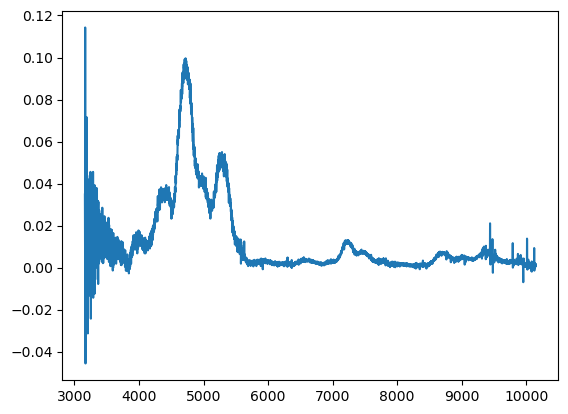

In [142]:
# read in the spectra as an instance of pdastroclass for ease of computations later on. plot it
spec = pdastroclass()
spec.t = pd.read_csv('2023bee-combined-20240214_ap1.flm', skiprows=np.arange(0,8), names = ['wavelength', 'flux', 'dflux'], delimiter= ' ')
plt.plot(spec.t.wavelength, spec.t.flux)

(24.0, 12.0)

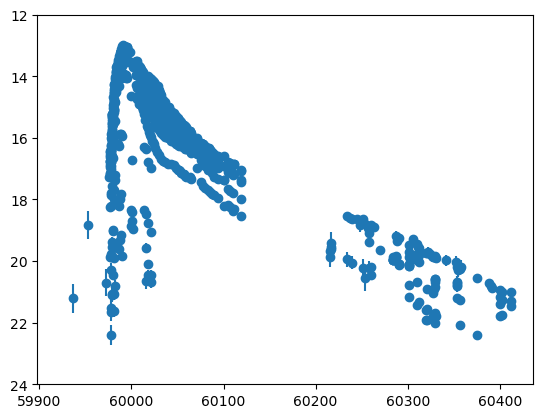

In [143]:
# read in the light curve, convert the dates to numeric data for correct ordering, do a primitive quality cut, and plot
lc = pdastroclass()
lc.t = pd.read_csv('2023bee_data.snana.txt', header=44, delim_whitespace=True)

end_ix=lc.ix_equal('MJD', 'END:')
lc.t=lc.t.drop(end_ix)
lc.t.MJD = pd.to_numeric(lc.t.MJD)

lc.t = lc.t[lc.t.MAGERR <= .5]

plt.scatter(lc.t.MJD, lc.t.MAG)
plt.errorbar(lc.t.MJD, lc.t.MAG, lc.t.MAGERR, ls='none')
plt.ylim(24,12)

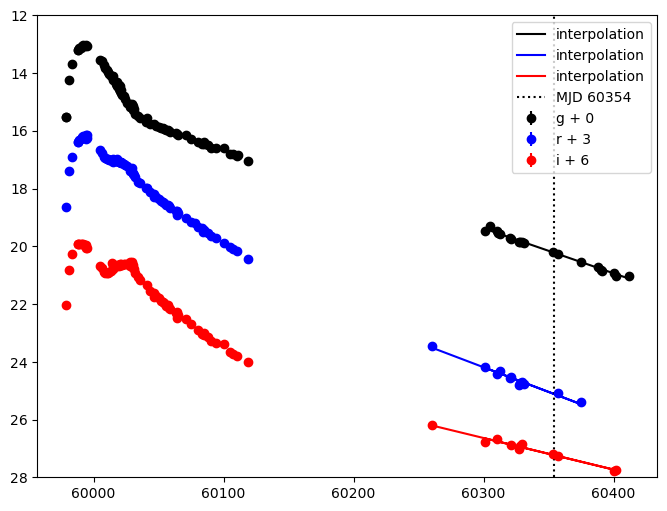

In [144]:
# separate out the light curve data from Pan-STARRS1's gri filters, and plot these three filters offset from one another.
# interpolate the magnitude in each filter at the day the spectrum was taken, using all data taken after MJD=60120, selected simply
# because that was a date on the early end of the gap in data evident through the plot. 

filters = lc.t.FLT.unique()
wanted_filts= [15,16,17]
usefilts = [filters[i] for i in wanted_filts]

plt.figure(figsize=(8,6))

colors=['black','b','r']
maglist = []

for i, filt in enumerate(usefilts): #plot ATLAS and ZTF bands
    # Filter out the data in certain filet and has reasonable uncertainty 
    ind = (lc.t.FLT==filt)&(lc.t.MAGERR>0.)&(lc.t.MAGERR<1.) 
    plt.errorbar(lc.t.MJD[ind], lc.t.MAG[ind]+3*i, lc.t.MAGERR[ind], linestyle = 'None', marker = 'o', 
                 label = filt + ' + ' + str(3*i), color = colors[i])
    
    # copy the quality cut indices for the current filter into a reindexed dataframe; separate out all indeces after 
    # the first "chunk" of observations ends and fit a line to those data; plot it and find the value at MJD=60345
    # to assume the SN magnitude on the day the spectrum was taken; add to a list 
    temp = lc.t[ind].copy().reset_index()
    ixs=(temp.MJD > 60120)
    a,b = np.polyfit(temp.MJD[ixs],temp.MAG[ixs],1)
    plt.plot(temp.MJD[ixs], a*temp.MJD[ixs]+(b+3*i), color=colors[i], label='interpolation')
    est_val = a*60354+b
    maglist.append(est_val)

plt.axvline(x=60354,color='black', ls='dotted', label = 'MJD 60354')
plt.ylim(28, 12)
plt.legend()

In [145]:
# find the difference between spectral magnitude and photometric magnitude in PS1 gri filters. 
# average the differences and convert to flux to determine a calibration constant for the spectrum

wavelength = np.array(spec.t.wavelength) * unit['AA']
flux = np.array(spec.t.flux) * unit['erg/s/cm**2/AA']

lib = pyphot.get_library()

diffs = []

f = lib['PS1_g']
fluxes = f.get_flux(wavelength, flux, axis=-1)
ps1_g_mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
diffs.append(ps1_g_mags - maglist[0])

f = lib['PS1_r']
fluxes = f.get_flux(wavelength, flux, axis=-1)
ps1_r_mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
diffs.append(ps1_r_mags - maglist[1])

f = lib['PS1_i']
fluxes = f.get_flux(wavelength, flux, axis=-1)
ps1_i_mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
diffs.append(ps1_i_mags - maglist[2])

avg_mag_diff = np.mean(diffs)
calib = mag2flux(-avg_mag_diff)
# c_unc = (1/2.5)*(10**((1/2.5)*avg_mag_diff))*np.log(10)*np.std(diffs) 
# print(calib, "+/-", c_unc)

Text(0, 0.5, '$10^{-15}$ erg/s/$cm^2$/Å')

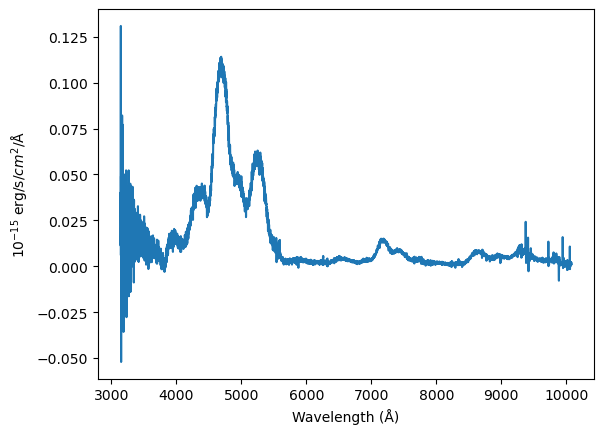

In [146]:
# flux calibrate and redshift the spectrum 
spec.t.flux = spec.t.flux*calib*(10**15)
spec.t.wavelength = spec.t.wavelength/1.0067

plt.plot(spec.t.wavelength, spec.t.flux)
plt.xlabel('Wavelength (Å)')
plt.ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

Text(0, 0.5, '$10^{-15}$ erg/s/$cm^2$/Å')

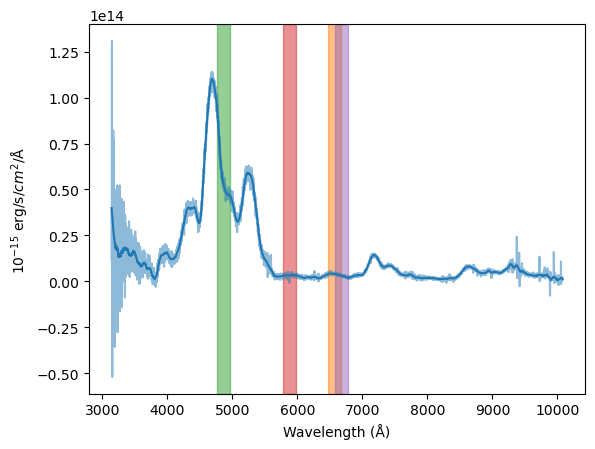

In [147]:
# smooth the spectrum, and then plot 200A ranges around four emission line locations 

smoothed_bee = savgol_filter(spec.t.flux, 85, 3)

halpha = 6562.79
hbeta = 4861.35
hei5875 = 5875.61
hei6678 = 6678.15

plt.plot(spec.t.wavelength, spec.t.flux*(10**15), alpha=.5)
plt.plot(spec.t.wavelength, smoothed_bee*(10**15), color='tab:blue')

plt.axvspan(halpha-100, halpha+100, alpha=0.5, color='tab:orange')
plt.axvspan(hbeta-100, hbeta+100, alpha=0.5, color='tab:green')
plt.axvspan(hei5875-100, hei5875+100, alpha=0.5, color='tab:red')
plt.axvspan(hei6678-100, hei6678+100, alpha=0.5, color='tab:purple')

plt.xlabel('Wavelength (Å)')
plt.ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

Text(0, 0.5, '$10^{-15}$ erg/s/$cm^2$/Å')

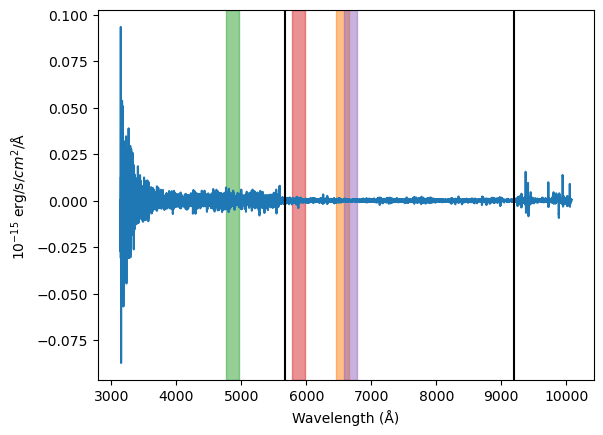

In [148]:
plt.plot(spec.t.wavelength, (spec.t.flux)-(smoothed_bee), drawstyle='steps')

plt.axvspan(halpha-100, halpha+100, alpha=0.5, color='tab:orange')
plt.axvspan(hbeta-100, hbeta+100, alpha=0.5, color='tab:green')
plt.axvspan(hei5875-100, hei5875+100, alpha=0.5, color='tab:red')
plt.axvspan(hei6678-100, hei6678+100, alpha=0.5, color='tab:purple')

plt.axis()

begin = 5675
end = 9200
plt.axvline(begin, color='black')
plt.axvline(end, color='black')

plt.xlabel('Wavelength (Å)')
plt.ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

In [149]:
# create list of indices in the "flat" part of the spectrum outside the 200A ranges around emission lines.
# subtract the smoothed spectrum from the unsmoothed one to get the root square mean of the spectrum.
# find the standard deviation of the difference of the spectrum and smoothed spectrum at the previously determiend indices 

p = spec.ix_inrange('wavelength', begin, hei5875-100)
q = spec.ix_inrange('wavelength', hei5875+100, halpha-100)
r = spec.ix_inrange('wavelength', hei6678+100, end)
s = spec.ix_inrange('wavelength', hbeta-700, hbeta-100)
t = spec.ix_inrange('wavelength', hbeta+700, hbeta+700)
valid_ixs_bee = list(np.concatenate([p, q, r]))
valid_ixs_bee_hb = list(np.concatenate([s,t]))

rms_bee = spec.t.flux-smoothed_bee

uncert_bee = tstd(spec.t.flux[valid_ixs_bee]-smoothed_bee[valid_ixs_bee])
uncert_bee_hb = tstd(spec.t.flux[valid_ixs_bee_hb]-smoothed_bee[valid_ixs_bee_hb])
print(rms_bee)
print(uncert_bee)
print(uncert_bee_hb)

0       0.000085
1      -0.023074
2      -0.027423
3      -0.016309
4       0.093349
          ...   
5900   -0.000487
5901   -0.000719
5902    0.000882
5903    0.000838
5904    0.000230
Name: flux, Length: 5905, dtype: float64
0.0005940265672458846
0.0021787721751693814


In [150]:
# sofia rest's code to create and add a gaussian to a function
class Gaussian:
    def __init__(self, sigma, peak_appmag):
        self.peak_appmag = peak_appmag
        self.sigma = sigma
        self.g = self.new_gaussian(peak_appmag, sigma)

    def new_gaussian(self, peak_flux, sigma):
        x = np.arange(-100,100,.01)
        g1 = Gaussian1D(amplitude=peak_flux, stddev=sigma)(x)
        g2 = Gaussian1D(amplitude=peak_flux, stddev=sigma)(x)

        ind = np.argmin(abs(x))
        g3 = np.copy(g1)
        g3[ind:] = g2[ind:]
        gauss = np.array([x,g3])
        return gauss
            
    # get interpolated function of gaussian at peak MJD (peak_mjd) and match to time array (mjds)
    def gauss2fn(self, mjds, peak_mjd):
        g = deepcopy(self.g)
        g[0,:] += peak_mjd
                
        # interpolate gaussian
        fn = interp1d(g[0],g[1],bounds_error=False,fill_value=0)
        fn = fn(mjds)
        return fn 
            
    def __str__(self):
        return f'Gaussian with peak app mag {self.peak_appmag:0.2f} and sigma_sim {self.sigma}'

In [151]:
def add_gaussian(pdastrodf, c, uncert, smoothed, emission_line, width, ix_range, snname, linename: str, xlims: list, ylims_plot1: list, ylims_plot2: list, gcolor='r', split_legend=True, legend_position=None, legend2newline=False):    
    """
    add a gaussian to the spectrum and plot it (top plot); subtract the smoothed spectrum from everything and plot again (bottom plot)
    
    @param pdastrodf: an instance of pdastroclass, whose .t field houses the dataframe containing the spectrum
    @param c: the flux calibration constant. this assumes it has been multiplied by 10^15, and reports spectra in units of 10^-15 erg/s/cm^2/A 
    @param uncert: 1/3 the height of the gaussian; uncertainty/standard deviation of the spectral rms 
    @param smoothed: the smoothed spectrum
    @param emission_line: the emission line around which to center the gaussian
    @param width: the sigma of the gaussian, so roughly 1/3 its width 
    @param ix_range: the number of indices to either side of the center to apply the gaussian to
    @param snname: the name of the supernova (or other object) whose spectrum is being used; to be used in the legend
    @param linename: the name of the emission line being investigaed; to be used in the legend
    @param xlims: a list of x limits across both graphs 
    @param ylims_plot1: the y limits for the top plot
    @param ylims_plot2: the y limits for the bottom plot
    @param gcolor: the color of the gaussian overlay; default is red
    @param split_legend: split the legend into two legends to avoid covering the plot; default is true
    @param legend_position: where to position the legend(s); takes a list if split_legend is true
    @param legend2newline: split the name of a line in the legend up further to make it take up vertical space rather than horizontal 
    """
    ix = pdastrodf.ix_inrange('wavelength', emission_line-ix_range, emission_line+ix_range)

    gaussian = Gaussian(width, 3*uncert)
    simflux = gaussian.gauss2fn(pdastrodf.t.loc[ix,'wavelength'], emission_line)
    pdastrodf.t['sim']=pdastrodf.t['flux'].copy()
    pdastrodf.t.sim[ix] += (simflux*c)
    smoothed_sim = smoothed.copy()
    smoothed_sim[ix] += (simflux*c)

    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[2,1]})

    ax[0].axvspan(emission_line-(width*3), emission_line+(width*3), alpha=0.15, color='black')
    ax[0].axvline(emission_line, linestyle='dotted', color='black', label=linename)
    ax[0].axvline(emission_line-(width*3), linestyle='dotted', color='black')
    ax[0].axvline(emission_line+(width*3), linestyle='dotted', color='black')

    stepspec, = ax[0].plot(pdastrodf.t.wavelength, pdastrodf.t.flux, drawstyle='steps', color='black', alpha=.5, label=snname)
    if legend2newline is True:
        stepsim, = ax[0].plot(pdastrodf.t.wavelength[ix], pdastrodf.t.sim[ix], drawstyle='steps', linestyle='dashed', color='black', alpha=.75, label=snname +' \n+ '+ linename + ' \nflux limit')
    else: 
        stepsim, = ax[0].plot(pdastrodf.t.wavelength[ix], pdastrodf.t.sim[ix], drawstyle='steps', linestyle='dashed', color='black', alpha=.75, label=snname+' \n+ '+ linename + ' flux limit')

    smoothspec, = ax[0].plot(pdastrodf.t.wavelength, smoothed, color='b', label=snname +' \nsmoothed')
    if legend2newline is True:
        smoothsim, = ax[0].plot(pdastrodf.t.wavelength[ix], smoothed_sim[ix], color=gcolor, label= snname + ' \nflux limit')
    else:
        smoothsim, = ax[0].plot(pdastrodf.t.wavelength[ix], smoothed_sim[ix], color=gcolor, label= snname + ' flux limit')

    ax[0].axis([xlims[0],xlims[1],ylims_plot1[0],ylims_plot1[1]])

    ax[1].plot(pdastrodf.t.wavelength, pdastrodf.t.flux-smoothed, drawstyle='steps',color='black', alpha=.5)
    ax[1].plot(pdastrodf.t.wavelength[ix], pdastrodf.t.sim[ix]-smoothed[ix], drawstyle='steps', linestyle='dashed', color='black', alpha=.75)

    ax[1].plot(pdastrodf.t.wavelength, np.zeros(len(pdastrodf.t.wavelength)), color='b')
    ax[1].plot(pdastrodf.t.wavelength[ix], smoothed_sim[ix]-smoothed[ix], color=gcolor)

    ax[1].axvspan(emission_line-(width*3), emission_line+(width*3), alpha=0.15, color='black')
    ax[1].axvline(emission_line, linestyle='dotted', color='black', label=linename)
    ax[1].axvline(emission_line-(width*3), linestyle='dotted', color='black')
    ax[1].axvline(emission_line+(width*3), linestyle='dotted', color='black')

    ax[1].set_ylim(ylims_plot2[0], ylims_plot2[1])

    ax[1].set_xlabel('Wavelength (Å)')
    ax[0].set_ylabel('$10^{-15}$ erg/s/$cm^2$/Å')
    ax[1].set_ylabel('$10^{-15}$ erg/s/$cm^2$/Å')

    if split_legend:
        if legend_position is None:
            legend1 = ax[0].legend(handles=[stepspec, smoothspec], loc='upper right')
            ax[0].add_artist(legend1)
            ax[0].legend(handles=[stepsim, smoothsim], loc='upper left')
        else: 
            legend1 = ax[0].legend(handles=[stepspec, smoothspec], loc=legend_position[0])
            ax[0].add_artist(legend1)
            ax[0].legend(handles=[stepsim, smoothsim], loc=legend_position[1])
    else:
        if legend_position is None:
            ax[0].legend()
        else: 
            ax[0].legend(loc=legend_position)
    

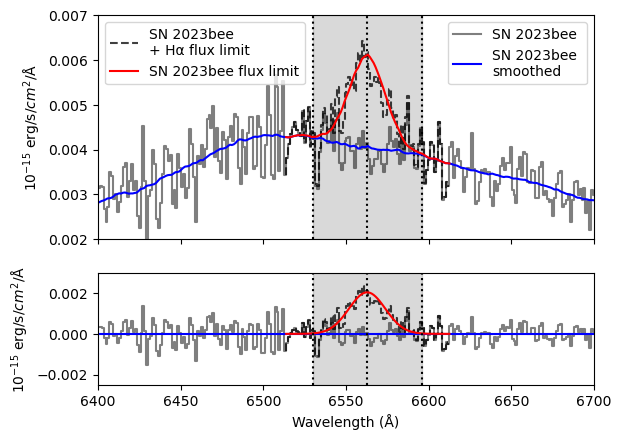

In [152]:
# add gaussian around halpha in sn2023bee
add_gaussian(spec, calib*(10**15), uncert_bee, smoothed_bee, halpha, 11, 50, 'SN 2023bee', 'Hα', [6400,6700], [.002,.007], [-.0025, .003], split_legend=True)

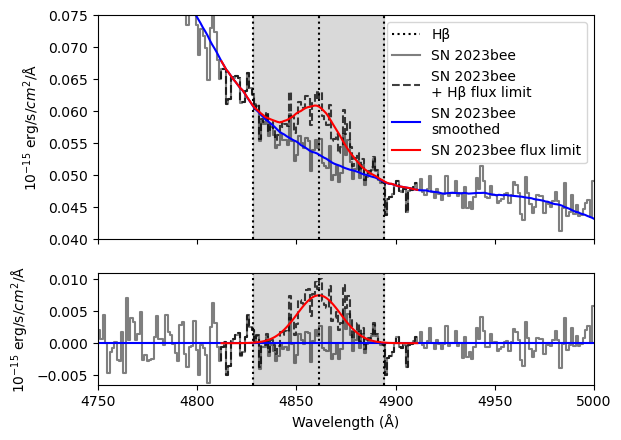

In [153]:
# add gaussian around hbeta in sn2023bee
add_gaussian(spec, calib*(10**15), uncert_bee_hb, smoothed_bee, hbeta, 11, 50,'SN 2023bee', 'Hβ', [4750,5000], [.04,.075], [-.0065, .011], split_legend=False)

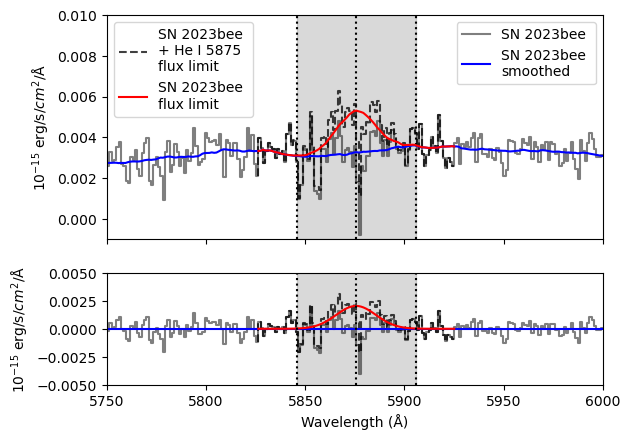

In [154]:
# add gaussian around He I 5875 in sn2023bee
add_gaussian(spec, calib*(10**15), uncert_bee, smoothed_bee, hei5875, 10, 50, 'SN 2023bee', 'He I 5875', [5750,6000], [-.001,.01], [-.005, .005], split_legend=True, legend2newline=True)

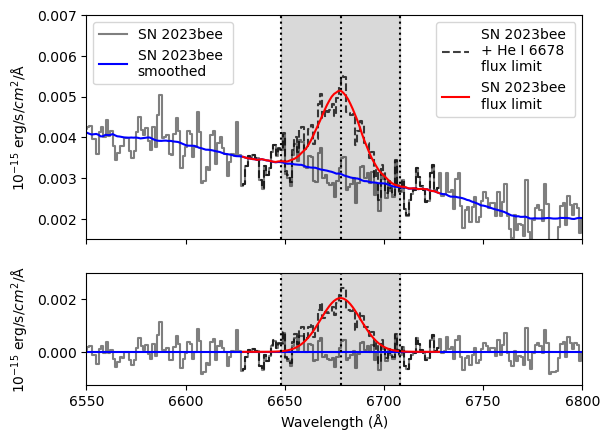

In [155]:
# add gaussian around He I 6678 in sn2023bee
add_gaussian(spec, calib*(10**15), uncert_bee, smoothed_bee, hei6678, 10, 50, 'SN 2023bee', 'He I 6678', [6550,6800], [.0015,.007], [-.00125, .003], split_legend=True, legend2newline=True, legend_position=['upper left', 'upper right'])

/var/folders/6w/hdrgkhvj5gs8m0p18llgfyhh0002wp/T/ipykernel_41179/1619165711.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdastrodf.t.sim[ix] += (simflux*c)


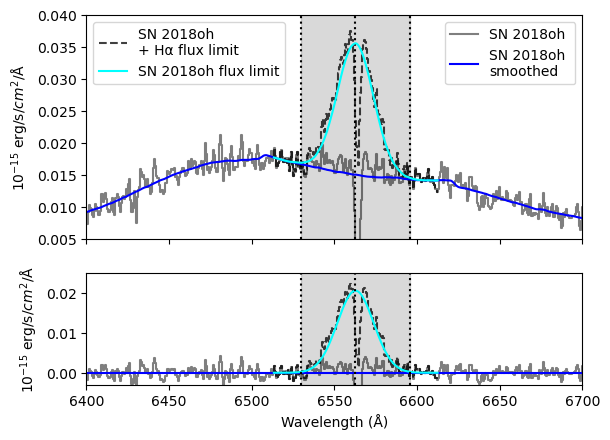

In [165]:
# read in the spectrum for SN2018oh, split it into LRIS and DEIMOS spectra, smooth them, determine rms and uncertainty in rms, add gaussian around halpha
spec_oh = pd.DataFrame()
deimosspec = pdastroclass()
lrisspec = pdastroclass()

spec_oh = pd.read_csv('./other_sne/2018oh_2spec.txt', skiprows=np.arange(0,25), names = ['instrument','wavelength', 'flux', 'dflux'], delim_whitespace=True)
deimosspec.t = spec_oh.loc[spec_oh['instrument'].eq("DEIMOS")].copy()
lrisspec.t = spec_oh.loc[spec_oh['instrument'].eq("LRIS")].copy().reset_index()

deimosspec.t.flux = deimosspec.t.flux*(10**15)
deimosspec.t.wavelength = deimosspec.t.wavelength/1.010981

lrisspec.t.flux = lrisspec.t.flux*(10**15)
lrisspec.t.wavelength = lrisspec.t.wavelength/1.010981

smoothed_oh_deimos = savgol_filter(deimosspec.t.flux, 181, 2)
smoothed_oh_lris = savgol_filter(lrisspec.t.flux, 181, 2)

p = deimosspec.ix_inrange('wavelength', hei5875+100,halpha-100)
q = deimosspec.ix_inrange('wavelength', hei6678+100, 7100)
r = deimosspec.ix_inrange('wavelength', hbeta-200, hbeta-100)
s = deimosspec.ix_inrange('wavelength', hbeta+100, hbeta+800)
valid_ixs_oh = list(np.concatenate([p, q]))
valid_ixs_oh_hb = list(np.concatenate([r, s]))

rms = deimosspec.t.flux-smoothed_oh_deimos
uncert_oh = tstd(deimosspec.t.flux[valid_ixs_oh]-smoothed_bee[valid_ixs_oh])
uncert_oh_hb = tstd(deimosspec.t.flux[valid_ixs_oh_hb]-smoothed_bee[valid_ixs_oh_hb])

add_gaussian(deimosspec, 1, uncert_oh, smoothed_oh_deimos, halpha, 11, 50, 'SN 2018oh', 'Hα', [6400,6700], [0.005,.04], [-.003, .025], gcolor='cyan', split_legend=True)

In [166]:
# read in the spectrum for 2017cbv, extract the GMOS optical spectrum from Jan 9, 2018, convert indices with flux = NaN-representing -9.9 into NaNs and drop; smooth
gmos1spec = pdastroclass()
spec_cbv = pd.read_csv('./other_sne/2017cbv_3spectra.txt', skiprows=np.arange(0,24), names = ['instrument','unit', 'wavelength', 'flux'], delim_whitespace=True)
gmos1spec.t = spec_cbv.loc[spec_cbv['instrument'].eq("GMOS_1")].copy().reset_index()
gmos1spec.t = gmos1spec.t.replace(-9.9, np.nan)
gmos1spec.t = gmos1spec.t.dropna()
gmos1spec.t.wavelength = gmos1spec.t.wavelength/1.003999
smoothed_cbv = savgol_filter(gmos1spec.t.flux, 101, 3)

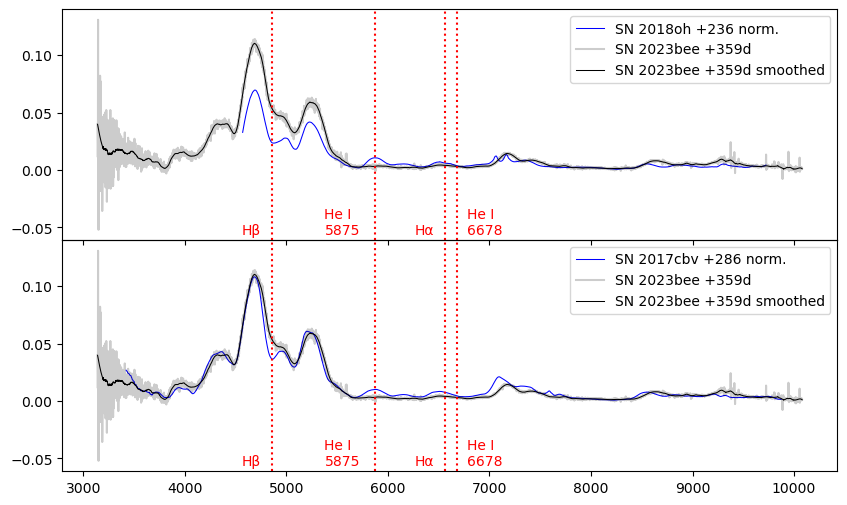

In [167]:
# normalize and plot the smoothed 18oh and 17cbv spectra overtop the smoothed and unsmoothed 23bee spectrum; indicate wavelengths of examined emission lines 

fig, ax = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0)
fig.set_figwidth(10)
fig.set_figheight(6)

ixs_bee = spec.ix_inrange('wavelength',7500,8500)
ixs_oh = deimosspec.ix_inrange('wavelength',7500,8500)
med_bee = np.median(spec.t.flux[ixs_bee])
med_oh = np.median(deimosspec.t.flux[ixs_oh])
constant = med_bee/med_oh

ax[0].plot(deimosspec.t.wavelength, smoothed_oh_deimos*constant,color='b',label='SN 2018oh +236 norm.', lw=.75)
ax[0].plot(spec.t.wavelength, spec.t.flux, color='black',alpha=.2, label='SN 2023bee +359d')
ax[0].plot(spec.t.wavelength, smoothed_bee, color='black',label='SN 2023bee +359d smoothed', lw=.75)
ax[0].axvline(halpha, linestyle='dotted', color='r')
ax[0].text(halpha-300,ax[0].get_ylim()[0]+.005,"Hα", color='r')
ax[0].axvline(hbeta, linestyle='dotted', color='r')
ax[0].text(hbeta-300,ax[0].get_ylim()[0]+.005,"Hβ", color='r')
ax[0].axvline(hei5875, linestyle='dotted', color='r')
ax[0].text(hei5875-500,ax[0].get_ylim()[0]+.005,"He I\n5875", color='r')
ax[0].axvline(hei6678, linestyle='dotted', color='r')
ax[0].text(hei5875+900,ax[0].get_ylim()[0]+.005,"He I \n6678", color='r')
ax[0].legend()

ixs_bee = spec.ix_inrange('wavelength',7800,8400)
ixs_cbv = gmos1spec.ix_inrange('wavelength',7800,8400)
med_bee = np.median(spec.t.flux[ixs_bee])
med_cbv = np.median(gmos1spec.t.flux[ixs_cbv])
constant = med_bee/med_cbv

ax[1].plot(gmos1spec.t.wavelength, smoothed_cbv*constant,color='b',label='SN 2017cbv +286 norm.', lw=.75)
ax[1].plot(spec.t.wavelength, spec.t.flux, color='black',alpha=.2, label='SN 2023bee +359d')
ax[1].plot(spec.t.wavelength, smoothed_bee, color='black',label='SN 2023bee +359d smoothed', lw=.75)
ax[1].set(facecolor='none')
ax[1].axvline(halpha, linestyle='dotted', color='r')
ax[1].text(halpha-300,ax[0].get_ylim()[0]+.005,"Hα", color='r')
ax[1].axvline(hbeta, linestyle='dotted', color='r')
ax[1].text(hbeta-300,ax[0].get_ylim()[0]+.005,"Hβ", color='r')
ax[1].axvline(hei5875, linestyle='dotted', color='r')
ax[1].text(hei5875-500,ax[0].get_ylim()[0]+.005,"He I\n5875", color='r')
ax[1].axvline(hei6678, linestyle='dotted', color='r')
ax[1].text(hei5875+900,ax[0].get_ylim()[0]+.005,"He I \n6678", color='r')
ax[1].legend()